<p align="center"><img src="https://raw.githubusercontent.com/IntelRealSense/librealsense/master/doc/img/realsense.png" width="70%" /><br><br></p>

## Getting the Data
This notebook is intended to showcase effect of post processing filters

In [4]:
!wget -N https://librealsense.intel.com/rs-tests/TestData/stairs.bag
print("Data is Ready")

Data is Ready


'wget' is not recognized as an internal or external command,
operable program or batch file.


In order to extract and visualise the data we will need to import python libraries:

In [1]:
import numpy as np                        # fundamental package for scientific computing
import matplotlib.pyplot as plt           # 2D plotting library producing publication quality figures
import pyrealsense2 as rs                 # Intel RealSense cross-platform open-source API
print("Environment Ready")

Environment Ready


## Capturing Depth Frame

In [2]:
# Setup:
pipe = rs.pipeline()
cfg = rs.config()
cfg.enable_device_from_file("../dataset/PPT/183847/20230315_183847.bag")
profile = pipe.start(cfg)

# Skip 5 first frames to give the Auto-Exposure time to adjust
for x in range(5):
  pipe.wait_for_frames()
  
# Store next frameset for later processing:
frameset = pipe.wait_for_frames()
depth_frame = frameset.get_depth_frame()

# Cleanup:
pipe.stop()
print("Frames Captured")

Frames Captured


## Visualising the Data

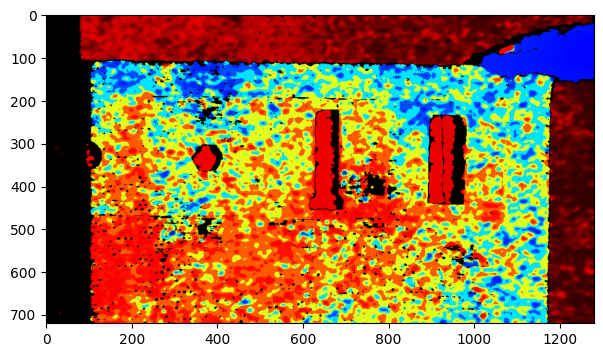

In [3]:
colorizer = rs.colorizer()
colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())

plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [8, 4]
plt.imshow(colorized_depth)

## Applying Filters

### Decimation
When using Depth-from-Stereo solution, z-accuracy is related to original spacial resolution. 

If you are satisfied with lower spatial resolution, the [**Decimation Filter**](https://github.com/IntelRealSense/librealsense/blob/master/doc/post-processing-filters.md#decimation-filter) will reduce spatial resolution preserving z-accuracy and performing some rudamentary hole-filling.

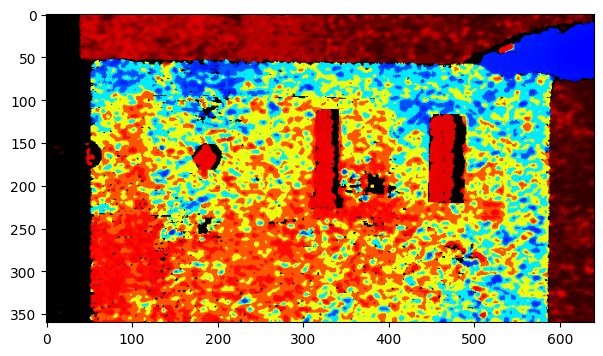

In [4]:
decimation = rs.decimation_filter()
decimated_depth = decimation.process(depth_frame)
colorized_depth = np.asanyarray(colorizer.colorize(decimated_depth).get_data())
plt.imshow(colorized_depth)

You can control the amount of decimation (liniar scale factor) via `filter_magnitude` option.

> Note the changing image resolution


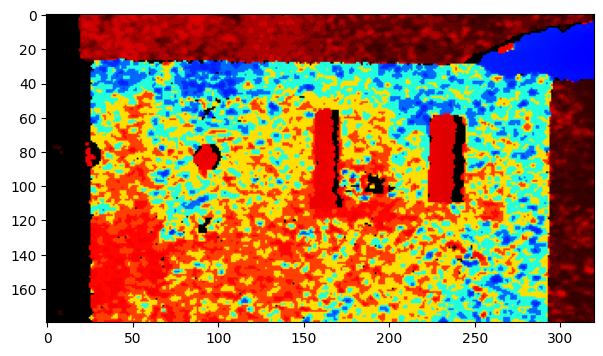

In [5]:
decimation.set_option(rs.option.filter_magnitude, 4)
decimated_depth = decimation.process(depth_frame)
colorized_depth = np.asanyarray(colorizer.colorize(decimated_depth).get_data())
plt.imshow(colorized_depth)

### Spatial Filter

[**Spatial Filter**](https://github.com/IntelRealSense/librealsense/blob/master/doc/post-processing-filters.md#spatial-edge-preserving-filter) is a fast implementation of [Domain-Transform Edge Preserving Smoothing](http://inf.ufrgs.br/~eslgastal/DomainTransform/)

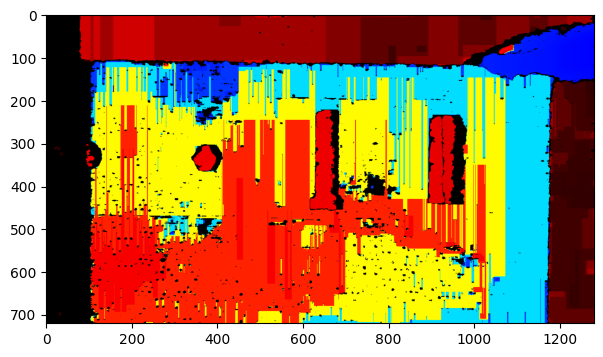

In [6]:
spatial = rs.spatial_filter()
filtered_depth = spatial.process(depth_frame)
colorized_depth = np.asanyarray(colorizer.colorize(filtered_depth).get_data())
plt.imshow(colorized_depth)

We can emphesize the effect of the filter by cranking-up `smooth_alpha` and `smooth_delta` options:

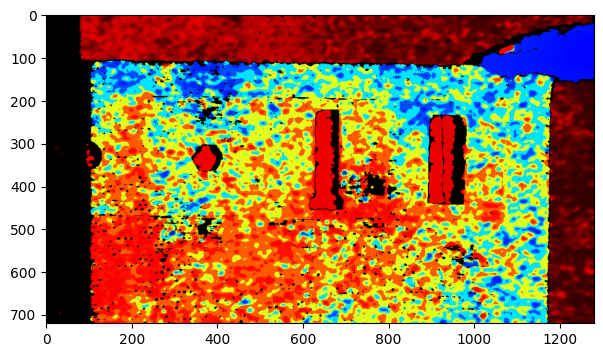

In [7]:
spatial.set_option(rs.option.filter_magnitude, 5)
spatial.set_option(rs.option.filter_smooth_alpha, 1)
spatial.set_option(rs.option.filter_smooth_delta, 50)
filtered_depth = spatial.process(depth_frame)
colorized_depth = np.asanyarray(colorizer.colorize(filtered_depth).get_data())
plt.imshow(colorized_depth)

The filter also offers some basic spatial **hole filling** capabilities:

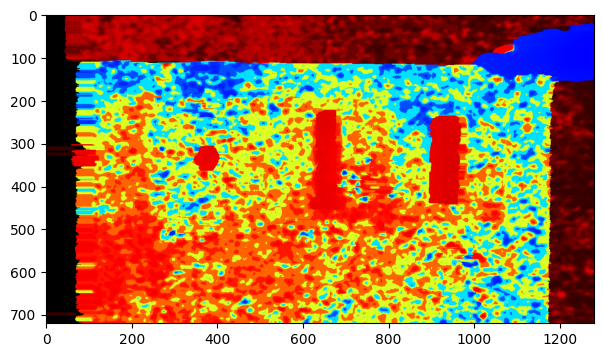

In [8]:
spatial.set_option(rs.option.holes_fill, 3)
filtered_depth = spatial.process(depth_frame)
colorized_depth = np.asanyarray(colorizer.colorize(filtered_depth).get_data())
plt.imshow(colorized_depth)

### Temporal Filter

Our implementation of [**Temporal Filter**](https://github.com/IntelRealSense/librealsense/blob/master/doc/post-processing-filters.md#temporal-filter) does basic temporal smoothing and hole-filling. It is meaningless when applied to a single frame, so let's capture several consecutive frames:

In [9]:
profile = pipe.start(cfg)

frames = []
for x in range(10):
    frameset = pipe.wait_for_frames()
    frames.append(frameset.get_depth_frame())

pipe.stop()
print("Frames Captured")

Frames Captured


Next, we need to "feed" the frames to the filter one by one:

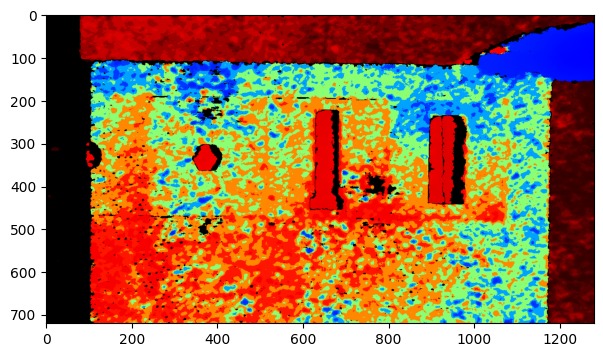

In [10]:
temporal = rs.temporal_filter()
for x in range(10):
    temp_filtered = temporal.process(frames[x])
colorized_depth = np.asanyarray(colorizer.colorize(temp_filtered).get_data())
plt.imshow(colorized_depth)

You can modify filter options to fine tune the result (with any temporal filtering there is a trade-off between smoothing and motion)

### Hole Filling
[Hole Filling](https://github.com/IntelRealSense/librealsense/blob/master/doc/post-processing-filters.md#holes-filling-filter) filter offers additional layer of depth exterpolation:

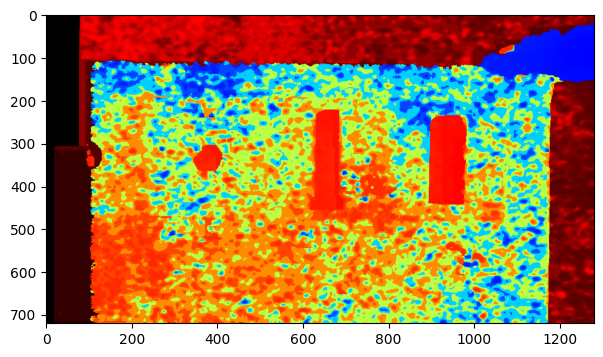

In [11]:
hole_filling = rs.hole_filling_filter()
filled_depth = hole_filling.process(depth_frame)
colorized_depth = np.asanyarray(colorizer.colorize(filled_depth).get_data())
plt.imshow(colorized_depth)

## Putting Everything Together
These filters work best when applied sequentially one after another. At longer range, it also helps using `disparity_transform` to switch from depth representation to disparity form:

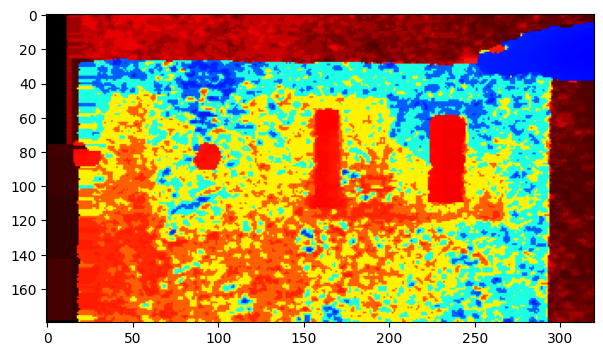

In [12]:
depth_to_disparity = rs.disparity_transform(True)
disparity_to_depth = rs.disparity_transform(False)

for x in range(10):
    frame = frames[x]
    frame = decimation.process(frame)
    frame = depth_to_disparity.process(frame)
    frame = spatial.process(frame)
    frame = temporal.process(frame)
    frame = disparity_to_depth.process(frame)
    frame = hole_filling.process(frame)

colorized_depth = np.asanyarray(colorizer.colorize(frame).get_data())
plt.imshow(colorized_depth)


> **Want to learn more?** Visit [realsense.intel.com](http://realsense.intel.com) and [github.com/IntelRealSense](http://www.github.com/IntelRealSense/librealsense)